In [1]:

import pandas as pd
import numpy as np
import yfinance as yf
from time import time




In [2]:

def Calc_rtn(df,ma_short,ma_long,ma_avl=True,short_pos=False,get_trades_info=False,Stop_loss=None):

    df1=df.copy()
    pl_pct=100
    Buy_prc=None
    Sell_prc=None
    pos=0
    dic={"Entry":[],"Buy":[],"Sell":[],"Exit":[],"Type":[],"PL%":[],"Cmpd_PL%":[]}

    if ma_avl==False:
        df1['Ma'+str(ma_short)]=df1.Close.rolling(ma_short).mean()
        df1['Ma'+str(ma_long)]=df1.Close.rolling(ma_long).mean()
        df1.dropna(inplace=True)
        ma_short='Ma'+str(ma_short)
        ma_long='Ma'+str(ma_long)

    for i in range(1,len(df1)):
        if (pos!=0) and (Stop_loss!=None):
            if pos>0:
                unrealized_pl=((df1.iloc[i].Close-Buy_prc)/Buy_prc)*100
                if unrealized_pl<-Stop_loss:
                    Sell_prc=df1.iloc[i].Close
                    dic["Sell"].append(Sell_prc)
                    pos-=1
                    pl_pct=pl_pct*(Sell_prc/Buy_prc)
                    dic["Exit"].append(df1.index[i])
                    dic['Type'].append("Long")
                    dic["PL%"].append(round(((Sell_prc/Buy_prc)-1)*100,2))
                    dic["Cmpd_PL%"].append(pl_pct)
                    Buy_prc=None
                    Sell_prc=None
                    #SEll
            elif pos<0:
                unrealized_pl=((Sell_prc-df1.iloc[i].Close)/Sell_prc)*100
                if unrealized_pl<-Stop_loss:
                    Buy_prc=df1.iloc[i].Close
                    pos+=1
                    dic["Buy"].append(Buy_prc)
                    pl_pct=pl_pct*(1+(Sell_prc-Buy_prc)/Sell_prc)
                    dic['Type'].append("Short")
                    dic["PL%"].append(round(((Sell_prc-Buy_prc)/Sell_prc)*100,2))
                    dic["Cmpd_PL%"].append(pl_pct)
                    dic["Exit"].append(df1.index[i])
                    Buy_prc=None

                            #Buy

        if (pos<=0) and ((i!=len(df1)-1))and((df1.iloc[i][ma_short]>df1.iloc[i][ma_long]) and (df1.iloc[i-1][ma_short]<df1.iloc[i-1][ma_long])):
            Buy_prc=df1.iloc[i].Close
            pos+=1
            dic["Buy"].append(Buy_prc)


            if pos==0:
                pl_pct=pl_pct*(1+(Sell_prc-Buy_prc)/Sell_prc)
                dic['Type'].append("Short")
                dic["PL%"].append(round(((Sell_prc-Buy_prc)/Sell_prc)*100,2))
                dic["Cmpd_PL%"].append(pl_pct)
                dic["Exit"].append(df1.index[i])
                Buy_prc=None
            else:
                dic["Entry"].append(df1.index[i])
            Sell_prc=None
            #Buy
        if (pos>=0)and (i!=len(df1)-1)and(((df1.iloc[i][ma_short]<df1.iloc[i][ma_long]) and (df1.iloc[i-1][ma_short]>df1.iloc[i-1][ma_long]))):


            if short_pos:
                Sell_prc=df1.iloc[i].Close
                pos-=1
                dic["Sell"].append(Sell_prc)
                if pos==0:
                    pl_pct=pl_pct*(Sell_prc/Buy_prc)
                    dic["Exit"].append(df1.index[i])
                    dic['Type'].append("Long")
                    dic["PL%"].append(round(((Sell_prc/Buy_prc)-1)*100,2))
                    dic["Cmpd_PL%"].append(pl_pct)
                    Sell_prc=None
                else:
                    dic["Entry"].append(df1.index[i])

                Buy_prc=None
            elif pos>0:
                Sell_prc=df1.iloc[i].Close
                dic["Sell"].append(Sell_prc)
                pos-=1
                pl_pct=pl_pct*(Sell_prc/Buy_prc)
                dic["Exit"].append(df1.index[i])
                dic['Type'].append("Long")
                dic["PL%"].append(round(((Sell_prc/Buy_prc)-1)*100,2))
                dic["Cmpd_PL%"].append(pl_pct)
                Buy_prc=None
                Sell_prc=None

        elif (i==len(df1)-1):
            if pos<0:
                Buy_prc=df1.iloc[i].Close
                pos+=1
                dic["Buy"].append(Buy_prc)
                dic['Type'].append("Short")
                dic["PL%"].append(round(((Sell_prc-Buy_prc)/Sell_prc)*100,2))
                dic["Cmpd_PL%"].append(pl_pct)
                dic["Exit"].append(df1.index[i])
                Buy_prc=None

            elif pos>0:
                Sell_prc=df1.iloc[i].Close
                pos-=1
                dic["Sell"].append(Sell_prc)
                pl_pct=pl_pct*(Sell_prc/Buy_prc)
                dic["Exit"].append(df1.index[i])
                dic['Type'].append("Long")
                dic["PL%"].append(round(((Sell_prc/Buy_prc)-1)*100,2))
                dic["Cmpd_PL%"].append(pl_pct)



    if get_trades_info:
        print(pd.DataFrame(dic))#Sell
    return(round((pl_pct-100),2))
    


In [3]:

df=yf.download("SBIN.ns",start="2010-01-01")
df.columns=(df.columns.get_level_values("Price"))
Calc_rtn(df,ma_short=50,ma_long=200,ma_avl=False,short_pos=True,get_trades_info=True,Stop_loss=10)




[*********************100%***********************]  1 of 1 completed


        Entry         Buy        Sell       Exit   Type    PL%   Cmpd_PL%
0  2011-02-10  229.753571  208.294403 2011-02-16  Short -10.30  89.697674
1  2012-03-14  199.234543  179.152863 2012-03-26   Long -10.08  80.656672
2  2012-09-13  179.153580  160.894043 2012-09-17  Short -11.35  71.503111
3  2012-11-02  185.433975  184.904129 2013-04-15   Long  -0.29  71.298803
4  2013-05-20  207.776978  185.326263 2013-05-24   Long -10.81  63.594826
5  2013-05-30  181.545990  183.450134 2014-04-22  Short   1.04  64.254916
6  2015-05-15  211.374359  256.215454 2016-07-20  Short  17.50  75.500377
7  2017-10-11  299.790619  232.293900 2017-10-25  Short -29.06  53.562531
8  2017-11-21  305.096283  273.262512 2018-01-16   Long -10.43  47.973812
9  2018-03-12  260.990387  233.308899 2018-06-12  Short -11.86  42.281846
10 2018-08-31  285.673035  252.639786 2018-09-18   Long -11.56  37.392666
11 2019-09-20  310.125092  278.383606 2019-11-25  Short -11.40  33.129129
12 2019-12-24  305.834442  275.061829 

np.float64(-56.0)

<Axes: title={'center': 'SBIN'}, xlabel='Date'>

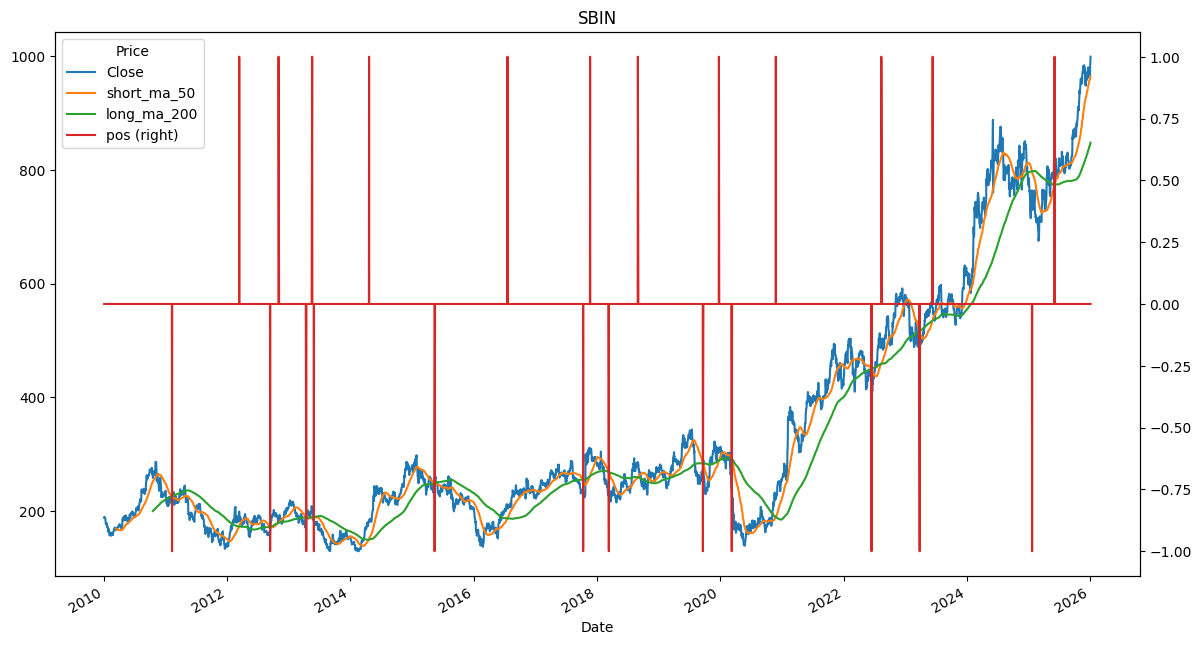

In [5]:

df["short_ma_50"]=df.Close.rolling(50).mean()
df["long_ma_200"]=df.Close.rolling(200).mean()

df["pos"] = 0

df.loc[
    (df["short_ma_50"] > df["long_ma_200"]) &
    (df["short_ma_50"].shift(1) <= df["long_ma_200"].shift(1)),
    "pos"
] = 1

df.loc[
    (df["short_ma_50"] < df["long_ma_200"]) &
    (df["short_ma_50"].shift(1) >= df["long_ma_200"].shift(1)),
    "pos"
] = -1
df[["Close","short_ma_50","long_ma_200","pos"]].plot(figsize=(14,8),title="SBIN",secondary_y="pos")





In [3]:

def Best_ma(df,S_colms,L_colms,ma_diff,take_short):
    L_list=[]
    S_list=[]
    rtn=[]

    for L in L_colms:
        for S in S_colms:
            if (int(L.strip("Ma"))-int(S.strip("Ma")))>=ma_diff:
                L_list.append(L)
                S_list.append(S)
                rtn.append(Calc_rtn(df,S,L,short_pos=take_short))
    return(S_list[rtn.index(max(rtn))],L_list[rtn.index(max(rtn))])




In [8]:

df=yf.download("TCS.ns",start="2010-01-01")
df.columns=(df.columns.get_level_values("Price"))




[*********************100%***********************]  1 of 1 completed


In [4]:

s=[]
l=[]
for a in range(20,150,5):
    s.append("Ma"+str(a))
    df["Ma"+str(a)]=df.Close.rolling(a).mean()
for b in range(50,250,10):
    l.append("Ma"+str(b))
    df["Ma"+str(b)]=df.Close.rolling(b).mean()

df.head()





NameError: name 'df' is not defined

In [11]:

Best_ma(df,S_colms=s,L_colms=l,ma_diff=1,take_short=False)




('Ma135', 'Ma140')

In [12]:

Calc_rtn(df,
         ma_short="Ma135",
         ma_long='Ma150',
         ma_avl=True,
         short_pos=False,
         get_trades_info=True,
         Stop_loss=None)




        Entry          Buy         Sell       Exit  Type    PL%    Cmpd_PL%
0  2011-07-26   421.309326   404.405243 2011-08-04  Long  -4.01   95.987726
1  2011-09-06   381.543549   366.966736 2011-09-22  Long  -3.82   92.320530
2  2011-09-28   386.709991   387.097382 2011-10-19  Long   0.10   92.413013
3  2012-02-29   453.446167   567.187317 2013-04-05  Long  25.08  115.593631
4  2013-04-10   579.338379   989.469910 2014-08-06  Long  70.79  197.425932
5  2014-08-21   960.180664  1041.449707 2015-04-15  Long   8.46  214.135930
6  2015-05-25  1030.847900  1030.370239 2015-06-05  Long  -0.05  214.036706
7  2015-07-03  1041.590942  1020.378418 2015-09-10  Long  -2.04  209.677741
8  2015-10-14   995.645081  1019.046265 2015-10-26  Long   2.35  214.605910
9  2015-11-02  1011.332825   954.485596 2015-12-15  Long  -5.62  202.542867
10 2016-06-15  1040.367920   924.376709 2016-11-29  Long -11.15  179.961247
11 2017-05-29  1055.409058  1041.410156 2017-09-22  Long  -1.33  177.574249
12 2017-10-1

np.float64(423.85)

In [13]:

Calc_rtn(df,
         ma_short="Ma30",
         ma_long='Ma100',
         ma_avl=True,
         short_pos=False,
         get_trades_info=True,
         Stop_loss=None)




        Entry          Buy         Sell       Exit  Type    PL%    Cmpd_PL%
0  2010-07-16   302.957092   391.453918 2011-03-21  Long  29.21  129.211010
1  2011-04-04   443.511139   416.841675 2011-07-28  Long  -6.01  121.441220
2  2011-08-01   418.945007   371.007690 2011-08-08  Long -11.44  107.545443
3  2011-11-11   418.539490   407.283295 2012-04-18  Long  -2.69  104.653118
4  2012-05-10   457.379608   469.417542 2012-12-14  Long   2.63  107.407520
5  2013-01-31   508.815948   531.752625 2013-06-25  Long   4.51  112.249293
6  2013-07-15   627.023376   850.597717 2014-04-23  Long  35.66  152.273417
7  2014-05-15   842.682800   782.569031 2014-05-19  Long  -7.13  141.410814
8  2014-06-23   880.134583   994.140076 2014-12-22  Long  12.95  159.728023
9  2015-03-02  1057.956543   983.506226 2015-05-04  Long  -7.04  148.487673
10 2015-06-17  1005.549744  1012.902222 2015-10-20  Long   0.73  149.573400
11 2015-10-23  1019.287476  1002.493958 2015-10-29  Long  -1.65  147.109067
12 2016-04-0

np.float64(282.27)

In [16]:

Calc_rtn(df,
         ma_short="Ma50",
         ma_long='Ma150',
         ma_avl=True,
         short_pos=False,
         get_trades_info=True,
         Stop_loss=None)




        Entry          Buy         Sell       Exit  Type    PL%    Cmpd_PL%
0  2011-12-12   436.802155   502.910919 2013-01-24  Long  15.13  115.134716
1  2013-01-29   509.118927   996.486694 2015-02-04  Long  95.73  225.350515
2  2015-03-12  1038.001221   995.851990 2015-05-19  Long  -4.06  216.199899
3  2015-07-02  1031.130371   960.391602 2015-11-17  Long  -6.86  201.367909
4  2016-05-09  1011.845093   979.158447 2016-10-18  Long  -3.23  194.862920
5  2017-03-14  1053.214478  1654.316528 2018-12-20  Long  57.07  306.077210
6  2019-03-26  1682.127563  1867.035156 2019-11-08  Long  10.99  339.722697
7  2019-12-24  1942.112793  1453.478760 2020-03-18  Long -25.16  254.248737
8  2020-07-07  2014.703979  3141.080566 2022-04-19  Long  55.91  396.393601
9  2022-12-12  3008.998535  3043.824463 2023-05-08  Long   1.16  400.981431
10 2023-07-17  3293.904053  4004.230713 2025-02-03  Long  21.56  487.452621


np.float64(387.45)

In [5]:

def Ma_Auto_update_stg(df,past_rows=10,L_ma_lower=40,L_ma_upper=70,S_ma_lower=10,S_ma_upper=40,short_ma_steps=3,long_ma_steps=10,ma_diff=10,take_short=True,Stop_loss=None):
    df1=df.copy()
    L_colms=[]
    S_colms=[]
    rtn=[]

    pl_pct=100
    Buy_prc=None
    Sell_prc=None
    pos=0
    dic={"Entry":[],"Buy":[],"Sell":[],"Exit":[],"Type":[],"PL%":[],"Cmpd_PL%":[],"S_ma":[],"L_ma":[]}
    for a in range(0,L_ma_upper-L_ma_lower,long_ma_steps):
        df1["Ma"+str(a+L_ma_lower)]=df1.Close.rolling(L_ma_lower+a).mean()
        L_colms.append("Ma"+str(a+L_ma_lower))
    for b in range(0,S_ma_upper-S_ma_lower,short_ma_steps):
        df1["Ma"+str(b+S_ma_lower)]=df1.Close.rolling(S_ma_lower+b).mean()
        S_colms.append("Ma"+str(b+S_ma_lower))
    df1.dropna(inplace=True)
    S_colm,L_colm=Best_ma(df=df1.iloc[:past_rows].copy(),S_colms=S_colms,L_colms=L_colms,ma_diff=ma_diff,take_short=take_short)



    for i in range(past_rows,len(df1)):
        if (pos!=0) and (Stop_loss!=None):
            if pos>0:
                unrealized_pl=((df1.iloc[i].Close-Buy_prc)/Buy_prc)*100
                if unrealized_pl<-Stop_loss:
                    Sell_prc=df1.iloc[i].Close
                    dic["Sell"].append(Sell_prc)
                    pos-=1
                    pl_pct=pl_pct*(Sell_prc/Buy_prc)
                    dic["Exit"].append(df1.index[i])
                    dic['Type'].append("Long")
                    dic["PL%"].append(round(((Sell_prc/Buy_prc)-1)*100,2))
                    dic["Cmpd_PL%"].append(pl_pct)
                    dic["S_ma"].append(S_colm)
                    dic["L_ma"].append(L_colm)

                    Buy_prc=None
                    Sell_prc=None

                    S_colm,L_colm=Best_ma(df1.iloc[i-past_rows:i].copy(),S_colms,L_colms,ma_diff,take_short)


                    #SEll
            elif pos<0:
                unrealized_pl=((Sell_prc-df1.iloc[i].Close)/Sell_prc)*100
                if unrealized_pl<-Stop_loss:
                    Buy_prc=df1.iloc[i].Close
                    pos+=1
                    dic["Buy"].append(Buy_prc)
                    pl_pct=pl_pct*(1+(Sell_prc-Buy_prc)/Sell_prc)
                    dic['Type'].append("Short")
                    dic["PL%"].append(round(((Sell_prc-Buy_prc)/Sell_prc)*100,2))
                    dic["Cmpd_PL%"].append(pl_pct)
                    dic["Exit"].append(df1.index[i])
                    dic["S_ma"].append(S_colm)
                    dic["L_ma"].append(L_colm)

                    Buy_prc=None
                    S_colm,L_colm=Best_ma(df1.iloc[i-past_rows:i].copy(),S_colms,L_colms,ma_diff,take_short)


        if (pos<=0):
            if   (((df1.iloc[i][S_colm]>df1.iloc[i][L_colm]) and (i!=len(df1)-1)and (df1.iloc[i-1][S_colm]<df1.iloc[i-1][L_colm]))):
                Buy_prc=df1.iloc[i].Close
                pos+=1

                dic["Buy"].append(Buy_prc)



                if pos==0:
                    dic["Exit"].append(df1.index[i])
                    pl_pct=pl_pct*(1+((Sell_prc-Buy_prc)/Sell_prc))
                    dic['Type'].append("Short")
                    dic["PL%"].append(round(((Sell_prc-Buy_prc)/Sell_prc)*100,2))
                    dic["Cmpd_PL%"].append(pl_pct)
                    dic["S_ma"].append(S_colm)
                    dic["L_ma"].append(L_colm)

                    Buy_prc=None
                    S_colm,L_colm=Best_ma(df1.iloc[i-past_rows:i].copy(),S_colms,L_colms,ma_diff,take_short)

                else:
                    dic["Entry"].append(df1.index[i])

                Sell_prc=None
            # print(pos,len(dic["Entry"]),len(dic["Buy"]),len(dic["Sell"]),len(dic["Exit"]),len(dic["Type"]),len(dic["PL%"]))
            #Buy
        if (pos>=0):
            if(((df1.iloc[i][S_colm]<df1.iloc[i][L_colm]) and (i!=len(df1)-1) and (df1.iloc[i-1][S_colm]>df1.iloc[i-1][L_colm]))):
                if take_short:
                    Sell_prc=df1.iloc[i].Close
                    dic["Sell"].append(Sell_prc)

                    pos-=1

                    if pos==0:
                        dic["Exit"].append(df1.index[i])
                        pl_pct=pl_pct*(Sell_prc/Buy_prc)
                        dic['Type'].append("Long")
                        dic["PL%"].append(round(((Sell_prc/Buy_prc)-1)*100,2))
                        dic["Cmpd_PL%"].append(pl_pct)
                        Sell_prc=None
                        dic["S_ma"].append(S_colm)
                        dic["L_ma"].append(L_colm)


                        S_colm,L_colm=Best_ma(df1.iloc[i-past_rows:i].copy(),S_colms,L_colms,ma_diff,take_short)
                    else:
                        dic["Entry"].append(df1.index[i])
                    Buy_prc=None
                elif pos>0:
                    Sell_prc=df1.iloc[i].Close
                    dic["Sell"].append(Sell_prc)

                    pos-=1

                    if pos==0:
                        dic["Exit"].append(df1.index[i])
                        pl_pct=pl_pct*(Sell_prc/Buy_prc)
                        dic['Type'].append("Long")
                        dic["PL%"].append(round(((Sell_prc/Buy_prc)-1)*100,2))
                        dic["Cmpd_PL%"].append(pl_pct)
                        dic["S_ma"].append(S_colm)
                        dic["L_ma"].append(L_colm)

                        Sell_prc=None

                        S_colm,L_colm=Best_ma(df1.iloc[i-past_rows:i].copy(),S_colms,L_colms,ma_diff,take_short)

                # print(pos,len(dic["Entry"]),len(dic["Buy"]),len(dic["Sell"]),len(dic["Exit"]),len(dic["Type"]),len(dic["PL%"]))
    if (i==len(df1)-1)&(pos!=0):
        # print(len(dic["Entry"]),len(dic["Buy"]),len(dic["Sell"]),len(dic["Exit"]),len(dic["Type"]),len(dic["PL%"]))

        if pos<0:
            Buy_prc=df1.iloc[i].Close
            pos+=1
            dic["Buy"].append(Buy_prc)

            dic["Exit"].append(df1.index[i])
            pl_pct=pl_pct*(1+((Sell_prc-Buy_prc)/Sell_prc))
            dic['Type'].append("Short")
            dic["PL%"].append(round(((Sell_prc-Buy_prc)/Sell_prc)*100,2))
            dic["Cmpd_PL%"].append(pl_pct)
            dic["S_ma"].append(S_colm)
            dic["L_ma"].append(L_colm)

            Buy_prc=None

        elif pos>0:
            Sell_prc=df1.iloc[i].Close
            dic["Sell"].append(Sell_prc)
            pos-=1

            dic["Exit"].append(df1.index[i])
            pl_pct=pl_pct*(Sell_prc/Buy_prc)
            dic['Type'].append("Long")
            dic["PL%"].append(round(((Sell_prc/Buy_prc)-1)*100,2))
            dic["Cmpd_PL%"].append(pl_pct)
            dic["S_ma"].append(S_colm)
            dic["L_ma"].append(L_colm)

    # print(len(dic["Entry"]),len(dic["Buy"]),len(dic["Sell"]),len(dic["Exit"]),len(dic["Type"]),len(dic["PL%"]),len(dic["Cmpd_PL%"]),len(dic["S_ma"]),len(dic["S_ma"]))
    print("Net Return: ",round((pl_pct-100),2))

    return(pd.DataFrame(dic))






        

In [23]:

stocks=["NTPC","TRENT","POWERGRID","MARUTI","RELIANCE","TCS","SUNPHARMA","TECHM","ITC","BAJFINANCE"]
results={}
for name in stocks:
    df=yf.download(name+".ns",start="2015-01-01")
    df.columns=(df.columns.get_level_values("Price"))
    t1=time()
    results[name]=Ma_Auto_update_stg(df,
                   past_rows=200,
                   L_ma_lower=50,
                   L_ma_upper=250,
                   S_ma_lower=10,
                   S_ma_upper=150,
                   short_ma_steps=5,
                   long_ma_steps=10,
                   take_short=False,
                   Stop_loss=10)
    print(name,"time taken(Minutes):",(time()-t1)/60)




[*********************100%***********************]  1 of 1 completed


Net Return:  209.21
NTPC time taken(Minutes): 3.830743106206258


[*********************100%***********************]  1 of 1 completed


Net Return:  239.77
TRENT time taken(Minutes): 5.494481118520101


[*********************100%***********************]  1 of 1 completed


Net Return:  12.69
POWERGRID time taken(Minutes): 3.4158364216486614


[*********************100%***********************]  1 of 1 completed


Net Return:  -15.82
MARUTI time taken(Minutes): 8.665407220522562


[*********************100%***********************]  1 of 1 completed


Net Return:  28.88
RELIANCE time taken(Minutes): 3.9783936659495036


[*********************100%***********************]  1 of 1 completed


Net Return:  202.09
TCS time taken(Minutes): 6.274836667378744


[*********************100%***********************]  1 of 1 completed


Net Return:  49.11
SUNPHARMA time taken(Minutes): 6.854625372091929


[*********************100%***********************]  1 of 1 completed


Net Return:  234.55
TECHM time taken(Minutes): 6.4996041814486185


[*********************100%***********************]  1 of 1 completed


Net Return:  125.75
ITC time taken(Minutes): 3.350492588678996


[*********************100%***********************]  1 of 1 completed


Net Return:  62.28
BAJFINANCE time taken(Minutes): 8.82977152665456


In [ ]:

stocks=["NTPC","TRENT","POWERGRID","MARUTI","RELIANCE","TCS","SUNPHARMA","TECHM","ITC","BAJFINANCE"]
results={}
for name in stocks:
    df=yf.download(name+".ns",start="2015-01-01")
    df.columns=(df.columns.get_level_values("Price"))
    t1=time()
    results[name]=Ma_Auto_update_stg(df,
                   past_rows=50,
                   L_ma_lower=50,
                   L_ma_upper=250,
                   S_ma_lower=10,
                   S_ma_upper=150,
                   short_ma_steps=5,
                   long_ma_steps=10,
                   take_short=False,
                   Stop_loss=10)
    print(name,"time taken(Minutes):",(time()-t1)/60)




[*********************100%***********************]  1 of 1 completed


Net Return:  -31.59
NTPC time taken(Minutes): 1.1756008783976237


[*********************100%***********************]  1 of 1 completed


Net Return:  1043.19
TRENT time taken(Minutes): 1.615721348921458


[*********************100%***********************]  1 of 1 completed


KeyboardInterrupt: 

In [8]:

stocks=["NTPC","TRENT","POWERGRID","MARUTI","RELIANCE","TCS","SUNPHARMA","TECHM","ITC","BAJFINANCE"]
results={}
for name in stocks:
    df=yf.download(name+".ns",start="2015-01-01")
    df.columns=(df.columns.get_level_values("Price"))
    t1=time()
    results[name]=Ma_Auto_update_stg(df,
                   past_rows=100,
                   L_ma_lower=2,
                   L_ma_upper=30,
                   S_ma_lower=5,
                   S_ma_upper=50,
                   short_ma_steps=3,
                   long_ma_steps=5,
                   take_short=False,
                   Stop_loss=10)
    print(name,"time taken(Minutes):",(time()-t1)/60)




[*********************100%***********************]  1 of 1 completed


Net Return:  355.13
NTPC time taken(Minutes): 0.21125643253326415


[*********************100%***********************]  1 of 1 completed


Net Return:  839.76
TRENT time taken(Minutes): 0.1840630610783895


[*********************100%***********************]  1 of 1 completed


Net Return:  -14.68
POWERGRID time taken(Minutes): 0.22684250275293985


[*********************100%***********************]  1 of 1 completed


Net Return:  62.21
MARUTI time taken(Minutes): 0.19373697837193807


[*********************100%***********************]  1 of 1 completed


Net Return:  197.1
RELIANCE time taken(Minutes): 0.20141261021296183


[*********************100%***********************]  1 of 1 completed


Net Return:  94.85
TCS time taken(Minutes): 0.22385880947113038


[*********************100%***********************]  1 of 1 completed


Net Return:  16.16
SUNPHARMA time taken(Minutes): 0.22480883995691936


[*********************100%***********************]  1 of 1 completed


Net Return:  304.39
TECHM time taken(Minutes): 0.1982977827390035


[*********************100%***********************]  1 of 1 completed


Net Return:  -14.32
ITC time taken(Minutes): 0.24000949859619142


[*********************100%***********************]  1 of 1 completed


Net Return:  783.93
BAJFINANCE time taken(Minutes): 0.18297342459360758


In [9]:
results['TRENT']

,Entry,Buy,Sell,Exit,Type,PL%,Cmpd_PL%,S_ma,L_ma
0,2015-09-23,126.330742,156.007355,2016-01-20,Long,23.49,123.491204,Ma8,Ma27
1,2016-03-03,150.556549,140.280106,2016-03-14,Long,-6.83,115.062143,Ma5,Ma27
2,2016-03-21,151.055420,160.668716,2016-05-31,Long,6.36,122.384797,Ma5,Ma17
3,2016-07-01,177.275711,215.512634,2016-10-05,Long,21.57,148.782198,Ma17,Ma27
4,2016-12-14,194.379120,237.629089,2017-03-03,Long,22.25,181.886708,Ma14,Ma27
5,2017-03-20,247.655212,236.154648,2017-03-27,Long,-4.64,173.440288,Ma5,Ma22
6,2017-03-28,242.101517,247.114563,2017-04-28,Long,2.07,177.031609,Ma11,Ma22
7,2017-06-09,245.492737,238.022247,2017-06-23,Long,-3.04,171.644432,Ma8,Ma22
8,2017-07-14,257.730530,291.711212,2017-09-29,Long,13.18,194.275026,Ma8,Ma22
9,2017-10-06,309.227631,296.201324,2017-10-30,Long,-4.21,186.091133,Ma5,Ma27


In [19]:
# 1 minute data results only Long position
stocks=["NTPC","TRENT","POWERGRID","MARUTI","RELIANCE","TCS","SUNPHARMA","TECHM","ITC","BAJFINANCE"]
results={}
for name in stocks:
    df=yf.download(name+".ns",interval="1m",start="2026-01-01")
    df.columns=(df.columns.get_level_values("Price"))
    t1=time()
    results[name]=Ma_Auto_update_stg(df,
                   past_rows=100,                                     
                    S_ma_lower=1,
                   S_ma_upper=30,                                 
                   L_ma_lower=3,
                   L_ma_upper=30,
                   
                   short_ma_steps=2,
                   long_ma_steps=4,
                   take_short=False,
                   Stop_loss=10)
    print(name,"time taken(Minutes):",(time()-t1)/60)




[*********************100%***********************]  1 of 1 completed


Net Return:  1.64
NTPC time taken(Minutes): 0.4701710224151611


[*********************100%***********************]  1 of 1 completed


Net Return:  1.99
TRENT time taken(Minutes): 0.44632381995519005


[*********************100%***********************]  1 of 1 completed


Net Return:  -2.26
POWERGRID time taken(Minutes): 0.7005137244860331


[*********************100%***********************]  1 of 1 completed


Net Return:  1.27
MARUTI time taken(Minutes): 0.5972517093022665


[*********************100%***********************]  1 of 1 completed


Net Return:  -0.75
RELIANCE time taken(Minutes): 0.5865062952041626


[*********************100%***********************]  1 of 1 completed


Net Return:  0.37
TCS time taken(Minutes): 0.5341726899147033


[*********************100%***********************]  1 of 1 completed


Net Return:  2.32
SUNPHARMA time taken(Minutes): 0.5287368575731913


[*********************100%***********************]  1 of 1 completed


Net Return:  -1.48
TECHM time taken(Minutes): 0.668154525756836


[*********************100%***********************]  1 of 1 completed


Net Return:  -7.44
ITC time taken(Minutes): 0.6271384874979655


[*********************100%***********************]  1 of 1 completed


Net Return:  -3.2
BAJFINANCE time taken(Minutes): 0.6427379012107849


In [20]:
# 1 minute data results only Long position
stocks=["NTPC","TRENT","POWERGRID","MARUTI","RELIANCE","TCS","SUNPHARMA","TECHM","ITC","BAJFINANCE"]
results={}
for name in stocks:
    df=yf.download(name+".ns",interval="1m",start="2026-01-01")
    df.columns=(df.columns.get_level_values("Price"))
    t1=time()
    results[name]=Ma_Auto_update_stg(df,
                   past_rows=300,
                   L_ma_lower=2,
                   L_ma_upper=30,
                   S_ma_lower=4,
                   S_ma_upper=50,
                   short_ma_steps=3,
                   long_ma_steps=5,
                   take_short=False,
                   Stop_loss=10)
    print(name,"time taken(Minutes):",(time()-t1)/60)




[*********************100%***********************]  1 of 1 completed


Net Return:  2.66
NTPC time taken(Minutes): 0.44753208955128987


[*********************100%***********************]  1 of 1 completed


Net Return:  2.42
TRENT time taken(Minutes): 0.3099876125653585


[*********************100%***********************]  1 of 1 completed


Net Return:  -1.68
POWERGRID time taken(Minutes): 0.5684221903483073


[*********************100%***********************]  1 of 1 completed


Net Return:  1.4
MARUTI time taken(Minutes): 0.5702930808067321


[*********************100%***********************]  1 of 1 completed


Net Return:  0.51
RELIANCE time taken(Minutes): 0.44336183071136476


[*********************100%***********************]  1 of 1 completed


Net Return:  0.57
TCS time taken(Minutes): 0.4285768429438273


[*********************100%***********************]  1 of 1 completed


Net Return:  2.5
SUNPHARMA time taken(Minutes): 0.499529500802358


[*********************100%***********************]  1 of 1 completed


Net Return:  0.13
TECHM time taken(Minutes): 0.39349884589513145


[*********************100%***********************]  1 of 1 completed


Net Return:  -6.18
ITC time taken(Minutes): 0.46597973108291624


[*********************100%***********************]  1 of 1 completed


Net Return:  -2.08
BAJFINANCE time taken(Minutes): 0.5553162693977356


In [21]:
results["TCS"]

,Entry,Buy,Sell,Exit,Type,PL%,Cmpd_PL%,S_ma,L_ma
0,2026-01-02 03:51:00+00:00,3224.500000,3235.000000,2026-01-02 04:34:00+00:00,Long,0.33,100.325632,Ma13,Ma27
1,2026-01-02 04:56:00+00:00,3235.500000,3233.600098,2026-01-02 04:59:00+00:00,Long,-0.06,100.266720,Ma13,Ma27
2,2026-01-02 05:01:00+00:00,3235.500000,3236.500000,2026-01-02 05:27:00+00:00,Long,0.03,100.297710,Ma13,Ma27
3,2026-01-02 05:30:00+00:00,3239.000000,3237.399902,2026-01-02 05:32:00+00:00,Long,-0.05,100.248162,Ma16,Ma27
4,2026-01-02 05:36:00+00:00,3238.699951,3241.000000,2026-01-02 06:24:00+00:00,Long,0.07,100.319356,Ma16,Ma27
5,2026-01-02 06:44:00+00:00,3240.899902,3240.399902,2026-01-02 07:15:00+00:00,Long,-0.02,100.303878,Ma10,Ma27
6,2026-01-02 07:31:00+00:00,3241.500000,3242.300049,2026-01-02 07:53:00+00:00,Long,0.02,100.328635,Ma10,Ma27
7,2026-01-02 08:05:00+00:00,3245.300049,3244.500000,2026-01-02 08:36:00+00:00,Long,-0.02,100.303901,Ma10,Ma27
8,2026-01-02 09:24:00+00:00,3245.399902,3235.100098,2026-01-05 03:46:00+00:00,Long,-0.32,99.985571,Ma16,Ma27
9,2026-01-05 04:16:00+00:00,3206.800049,3206.000000,2026-01-05 04:19:00+00:00,Long,-0.02,99.960626,Ma7,Ma17


In [22]:
# 1 minute data results only Long & Short position
stocks=["NTPC","TRENT","POWERGRID","MARUTI","RELIANCE","TCS","SUNPHARMA","TECHM","ITC","BAJFINANCE"]
results={}
for name in stocks:
    df=yf.download(name+".ns",interval="1m",start="2026-01-01")
    df.columns=(df.columns.get_level_values("Price"))
    t1=time()
    results[name]=Ma_Auto_update_stg(df,
                   past_rows=100,
                   L_ma_lower=2,
                   L_ma_upper=30,
                   S_ma_lower=5,
                   S_ma_upper=50,
                   short_ma_steps=3,
                   long_ma_steps=5,
                   take_short=True,
                   Stop_loss=10)
    print(name,"time taken(Minutes):",(time()-t1)/60)




[*********************100%***********************]  1 of 1 completed


Net Return:  -0.58
NTPC time taken(Minutes): 0.19394036531448364


[*********************100%***********************]  1 of 1 completed


Net Return:  13.34
TRENT time taken(Minutes): 0.15244744618733724


[*********************100%***********************]  1 of 1 completed


Net Return:  -0.81
POWERGRID time taken(Minutes): 0.23976449171702066


[*********************100%***********************]  1 of 1 completed


Net Return:  2.05
MARUTI time taken(Minutes): 0.1893765687942505


[*********************100%***********************]  1 of 1 completed


Net Return:  0.61
RELIANCE time taken(Minutes): 0.20144210656483968


[*********************100%***********************]  1 of 1 completed


Net Return:  0.22
TCS time taken(Minutes): 0.20542370478312175


[*********************100%***********************]  1 of 1 completed


Net Return:  -0.17
SUNPHARMA time taken(Minutes): 0.18372891346613565


[*********************100%***********************]  1 of 1 completed


Net Return:  -1.43
TECHM time taken(Minutes): 0.16046282052993774


[*********************100%***********************]  1 of 1 completed


Net Return:  -1.92
ITC time taken(Minutes): 0.1887797713279724


[*********************100%***********************]  1 of 1 completed


Net Return:  -1.0
BAJFINANCE time taken(Minutes): 0.23377835750579834
